--- Starting VERBOSE Training for TODDLER-SPECIFIC Models ---

--- [Stage 1] Loading and Cleaning Data ---

Data Head After Cleaning and Standardization:


,A1_Score,A2_Score,A3_Score,A4_Score,A5_Score,A6_Score,A7_Score,A8_Score,A9_Score,A10_Score,Age_Mons,Gender,Jaundice,Family_History_ASD,Class/ASD
0,0,0,0,0,0,0,1,1,0,1,28,f,yes,no,No
1,1,1,0,0,0,1,1,0,0,0,36,m,yes,no,Yes
2,1,0,0,0,0,0,1,1,0,1,36,m,yes,no,Yes
3,1,1,1,1,1,1,1,1,1,1,24,m,no,no,Yes
4,1,1,0,1,1,1,1,1,1,1,20,f,no,yes,Yes



Columns after final renaming:
['A1_Score', 'A2_Score', 'A3_Score', 'A4_Score', 'A5_Score', 'A6_Score', 'A7_Score', 'A8_Score', 'A9_Score', 'A10_Score', 'Age_Mons', 'Gender', 'Jaundice', 'Family_History_ASD', 'Class/ASD']
✅ Maximum toddler age found: 36 months.

--- Tuning Logistic Regression for toddlers ---
Fitting 3 folds for each of 3 candidates, totalling 9 fits
Best Parameters: {'C': 10}

Classification Report on Test Set:
              precision    recall  f1-score   support

          No       1.00      1.00      1.00        65
         Yes       1.00      1.00      1.00       146

    accuracy                           1.00       211
   macro avg       1.00      1.00      1.00       211
weighted avg       1.00      1.00      1.00       211



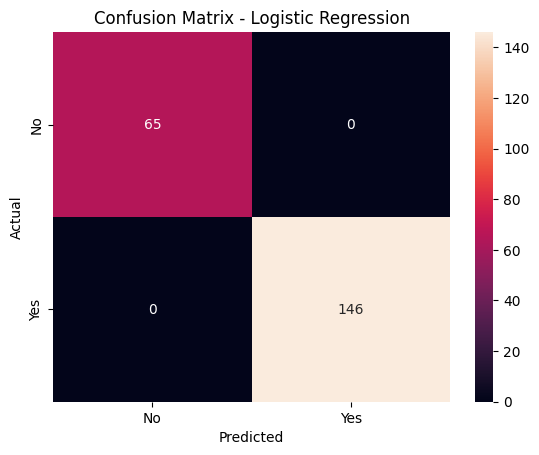


--- Tuning AdaBoost for toddlers ---
Fitting 3 folds for each of 2 candidates, totalling 6 fits
Best Parameters: {'n_estimators': 50}

Classification Report on Test Set:
              precision    recall  f1-score   support

          No       0.97      1.00      0.98        65
         Yes       1.00      0.99      0.99       146

    accuracy                           0.99       211
   macro avg       0.99      0.99      0.99       211
weighted avg       0.99      0.99      0.99       211



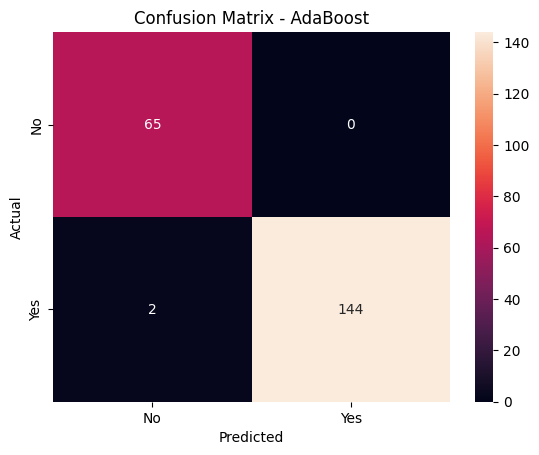


--- Tuning XGBoost for toddlers ---
Fitting 3 folds for each of 2 candidates, totalling 6 fits


C:\Users\hardi\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [21:37:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best Parameters: {'n_estimators': 200}

Classification Report on Test Set:
              precision    recall  f1-score   support

          No       0.94      0.98      0.96        65
         Yes       0.99      0.97      0.98       146

    accuracy                           0.98       211
   macro avg       0.97      0.98      0.97       211
weighted avg       0.98      0.98      0.98       211



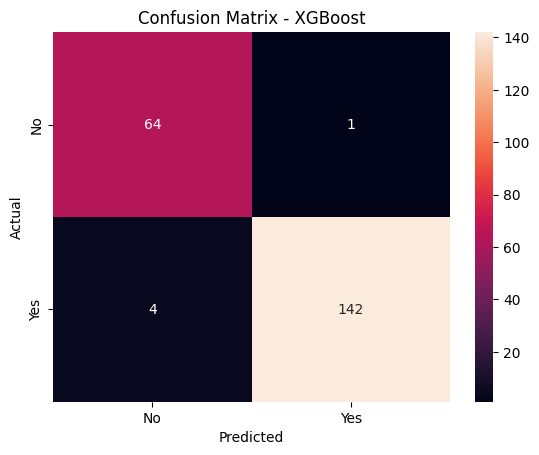


Full Model Performance Ranking (sorted by Recall):


,Model,Recall (Yes),Precision (Yes),Accuracy
0,Logistic Regression,1.000000,1.000000,1.000000
1,AdaBoost,0.986301,1.000000,0.990521
2,XGBoost,0.972603,0.993007,0.976303



--- Saving Top 3 Toddler Models ---
✅ Saved Rank 1: Logistic Regression with Recall: 1.0000
✅ Saved Rank 2: AdaBoost with Recall: 0.9863
✅ Saved Rank 3: XGBoost with Recall: 0.9726
✅ Toddler artifacts saved to 'models/toddler' directory.


In [9]:
import pandas as pd
import numpy as np
import os
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer
from imblearn.over_sampling import SMOTE
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# --- Import All 9 Models ---
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb

# from sklearn.neighbors import KNeighborsClassifier
# from sklearn.tree import DecisionTreeClassifier
# from sklearn.naive_bayes import GaussianNB
# from sklearn.svm import SVC
# from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


def train_toddler_models_verbose():
    print("=" * 60)
    print("--- Starting VERBOSE Training for TODDLER-SPECIFIC Models ---")
    print("=" * 60)

    # --- Stage 1: Data Loading and Cleaning ---
    print("\n--- [Stage 1] Loading and Cleaning Data ---")
    df = pd.read_csv(".\datasets\Toddler Autism dataset July 2018.csv", na_values=["?"])

    df.columns = df.columns.str.strip()

    rename_mapping = {
        "Class/ASD Traits": "Class/ASD",
        "Family_mem_with_ASD": "Family_History_ASD",
        "Sex": "Gender",
    }
    # Add A1-A10 to the mapping
    for i in range(1, 11):
        rename_mapping[f"A{i}"] = f"A{i}_Score"

    df.rename(columns=rename_mapping, inplace=True)

    # Drop unnecessary columns
    cols_to_drop = ["Case_No", "Qchat-10-Score", "Who completed the test", "Ethnicity"]
    df = df.drop(
        columns=[col for col in cols_to_drop if col in df.columns], errors="ignore"
    )

    print("\nData Head After Cleaning and Standardization:")
    display(df.head())
    print("\nColumns after final renaming:")
    print(df.columns.tolist())  # Add a print statement to verify the column names

    max_toddler_age_months = df["Age_Mons"].max()
    print(f"✅ Maximum toddler age found: {max_toddler_age_months} months.")

    # --- Stage 2: Preprocessing ---
    X = df.drop("Class/ASD", axis=1)
    y = df["Class/ASD"]

    target_encoder = LabelEncoder()
    y_encoded = target_encoder.fit_transform(y)

    X_train, X_test, y_train, y_test = train_test_split(
        X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
    )

    preprocessors = {"imputers": {}, "encoders": {}, "scaler": MinMaxScaler()}
    numerical_cols = X_train.select_dtypes(include=np.number).columns.tolist()
    categorical_cols = X_train.select_dtypes(include=["object"]).columns.tolist()

    # Process Numerical Columns
    num_imputer = SimpleImputer(strategy="median")
    X_train.loc[:, numerical_cols] = num_imputer.fit_transform(X_train[numerical_cols])
    X_test.loc[:, numerical_cols] = num_imputer.transform(X_test[numerical_cols])
    preprocessors["imputers"]["numerical"] = num_imputer

    # Process Categorical Columns
    for col in categorical_cols:
        cat_imputer = SimpleImputer(strategy="most_frequent")
        X_train.loc[:, col] = cat_imputer.fit_transform(X_train[[col]]).ravel()
        X_test.loc[:, col] = cat_imputer.transform(X_test[[col]]).ravel()
        preprocessors["imputers"][col] = cat_imputer

        le = LabelEncoder()
        X_train.loc[:, col] = le.fit_transform(X_train[col])
        X_test.loc[:, col] = le.transform(X_test[col])
        preprocessors["encoders"][col] = le

        X_train[col] = X_train[col].astype(int)
        X_test[col] = X_test[col].astype(int)

    # --- THE FIX TO REMOVE WARNINGS ---
    # Explicitly cast numerical columns to float before scaling.
    for col in numerical_cols:
        X_train[col] = X_train[col].astype(float)
        X_test[col] = X_test[col].astype(float)

    # Scale Numerical Columns
    scaler = MinMaxScaler()
    X_train.loc[:, numerical_cols] = scaler.fit_transform(X_train[numerical_cols])
    X_test.loc[:, numerical_cols] = scaler.transform(X_test[numerical_cols])
    preprocessors["scaler"] = scaler

    # Balance Data with SMOTE
    smote = SMOTE(random_state=42)
    X_train_resampled_np, y_train_resampled = smote.fit_resample(X_train, y_train)

    # Reconstruct DataFrame to fix dtypes for XGBoost
    X_train_resampled = pd.DataFrame(X_train_resampled_np, columns=X_train.columns)
    X_train_resampled = X_train_resampled.astype(X_train.dtypes.to_dict())

    preprocessors["feature_order"] = X_train.columns.tolist()

    # --- Stage 3: Train and Evaluate All 9 Models ---
    models = {
        "Logistic Regression": LogisticRegression(max_iter=1000, random_state=42),
        # "K-Nearest Neighbors": KNeighborsClassifier(),
        # "Decision Tree": DecisionTreeClassifier(random_state=42),
        # "Gaussian Naive Bayes": GaussianNB(),
        # "SVM": SVC(probability=True, random_state=42),
        # "Linear Discriminant Analysis": LinearDiscriminantAnalysis(),
        # "Random Forest": RandomForestClassifier(random_state=42),
        "AdaBoost": AdaBoostClassifier(random_state=42),
        "XGBoost": xgb.XGBClassifier(
            use_label_encoder=False, eval_metric="logloss", random_state=42
        ),
    }
    params = {
        "Logistic Regression": {"C": [0.1, 1, 10]},
        # "K-Nearest Neighbors": {"n_neighbors": [3, 5, 7]},
        # "Decision Tree": {"max_depth": [5, 10, None]},
        # "Gaussian Naive Bayes": {},
        # "SVM": {"C": [0.1, 1], "kernel": ["linear", "rbf"]},
        # "Linear Discriminant Analysis": {},
        # "Random Forest": {"n_estimators": [100, 200]},
        "AdaBoost": {"n_estimators": [50, 100]},
        "XGBoost": {"n_estimators": [100, 200]},
    }
    results = []
    trained_models = {}
    for name, model in models.items():
        print(f"\n--- Tuning {name} for toddlers ---")
        grid_search = GridSearchCV(
            model, params[name], cv=3, scoring="recall", n_jobs=-1, verbose=1
        )
        grid_search.fit(X_train_resampled, y_train_resampled)
        best_model = grid_search.best_estimator_
        y_pred = best_model.predict(X_test)

        print(f"Best Parameters: {grid_search.best_params_}")
        print("\nClassification Report on Test Set:")
        print(
            classification_report(y_test, y_pred, target_names=target_encoder.classes_)
        )

        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(
            cm,
            annot=True,
            fmt="d",
            xticklabels=target_encoder.classes_,
            yticklabels=target_encoder.classes_,
        )
        plt.title(f"Confusion Matrix - {name}")
        plt.xlabel("Predicted")
        plt.ylabel("Actual")
        plt.show()

        report = classification_report(
            y_test, y_pred, output_dict=True, target_names=target_encoder.classes_
        )
        results.append(
            {
                "Model": name,
                "Recall (Yes)": report["Yes"]["recall"],
                "Precision (Yes)": report["Yes"]["precision"],
                "Accuracy": report["accuracy"],
            }
        )
        trained_models[name] = best_model

    # --- Stage 4: Compare Models and Save Top 3 ---
    results_df = pd.DataFrame(results).sort_values(by="Recall (Yes)", ascending=False)

    print("\nFull Model Performance Ranking (sorted by Recall):")
    display(results_df)

    top_3_models = results_df.head(3)
    output_dir = "models/toddler"
    os.makedirs(output_dir, exist_ok=True)

    print("\n--- Saving Top 3 Toddler Models ---")
    for index, row in top_3_models.iterrows():
        rank = results_df.index.get_loc(index) + 1
        model_name = row["Model"]
        model_object = trained_models[model_name]
        filename = f"toddler_model_rank_{rank}_{model_name.replace(' ', '_')}.joblib"
        joblib.dump(model_object, os.path.join(output_dir, filename))
        print(
            f"✅ Saved Rank {rank}: {model_name} with Recall: {row['Recall (Yes)']:.4f}"
        )

    artifacts = {
        "preprocessors": preprocessors,
        "target_encoder": target_encoder,
        "max_toddler_age_months": int(max_toddler_age_months),
    }
    joblib.dump(artifacts, os.path.join(output_dir, "toddler_artifacts.joblib"))
    print(f"✅ Toddler artifacts saved to '{output_dir}' directory.")


if __name__ == "__main__":
    train_toddler_models_verbose()